<a href="https://colab.research.google.com/github/caro1ie/Auto_job_applier_linkedIn/blob/main/Modelo_entrenado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Librerias
import os
import random
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
# Clonar repositorio de GitHub
!git clone https://github.com/spMohanty/PlantVillage-Dataset.git


Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163235, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 163235 (delta 2), reused 0 (delta 0), pack-reused 163229 (from 1)
Receiving objects: 100% (163235/163235), 2.00 GiB | 31.04 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Updating files: 100% (182401/182401), done.


In [ ]:
# Ruta de imágenes
base_dir = "/content/PlantVillage-Dataset/raw/color/"
# Carpetas con imágenes de hojas sanas y enfermas
healthy_folders = ['Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy',
                   'Corn_(maize)___healthy', 'Grape___healthy', 'Peach___healthy', 'Pepper,_bell___healthy',
                   'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Strawberry___healthy',
                   'Tomato___healthy']
disease_folders = [folder for folder in os.listdir(base_dir) if "healthy" not in folder and folder != '.git']

# Diccionario para guardar las imágenes
sampled_data_dir = '/content/sample_data'
os.makedirs(sampled_data_dir, exist_ok=True)

# Diccionario para almacenar las rutas y sus respectivas carpetas
image_source = {}

# Función para agarrar muestra de imágenes de manera random de cada carpeta y guardar origen
def sample_images(folder_list, label, sample_size=1000):
    img_paths = []
    labels = []

    for folder in folder_list:
        folder_path = os.path.join(base_dir, folder)
        images = os.listdir(folder_path)
        sampled_images = random.sample(images, min(sample_size, len(images)))

        for img in sampled_images:
            img_src = os.path.join(folder_path, img)
            img_dst = os.path.join(sampled_data_dir, img)
            shutil.copy(img_src, img_dst)
            img_paths.append(img_dst)
            labels.append(label)
            # Guardar el origen de la imagen
            image_source[img_dst] = folder  # Aca se almacena la carpeta de origen

    return img_paths, labels

# Sample de imágenes de ambas carpetas
healthy_img_paths, healthy_labels = sample_images(healthy_folders, label=0, sample_size=1000)
disease_img_paths, disease_labels = sample_images(disease_folders, label=1, sample_size=1000)

# Combinar data de sanas y enfermas
all_img_paths = healthy_img_paths + disease_img_paths
all_labels = healthy_labels + disease_labels


In [ ]:
# Split train, test y val
train_paths, test_paths, train_labels, test_labels = train_test_split(all_img_paths, all_labels, test_size=0.2, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25, random_state=42)

# Generador de data (normalizar)
datagen = ImageDataGenerator(rescale=1./255)

# Generador personalizado que carga imágenes y rutas de origen (ajustado para solo devolver images y labels)
def create_generator(image_paths, labels, batch_size=32):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            images = []

            for img_path in batch_paths:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
                img = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img)

            images = np.array(images) / 255.0  # Normalize
            batch_labels = to_categorical(batch_labels, num_classes=2)  # One-hot encode the labels

            yield images, batch_labels  # Devolver solo images y labels

# Generadores de train, test y val con el generador ajustado
train_gen = create_generator(train_paths, train_labels)
val_gen = create_generator(val_paths, val_labels)
test_gen = create_generator(test_paths, test_labels)

In [ ]:
# Definir la arquitectura de la CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')  # 2 salidas para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Parámetros para entrenamiento
batch_size = 32
epochs = 10
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(val_paths) // batch_size


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Entrenar el modelo
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=validation_steps
)

Epoch 1/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 762s 1s/step - accuracy: 0.7719 - loss: 0.4546 - val_accuracy: 0.9193 - val_loss: 0.2143
Epoch 2/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 758s 1s/step - accuracy: 0.9264 - loss: 0.1804 - val_accuracy: 0.9620 - val_loss: 0.1199
Epoch 3/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 781s 1s/step - accuracy: 0.9555 - loss: 0.1122 - val_accuracy: 0.9670 - val_loss: 0.1011
Epoch 4/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 778s 1s/step - accuracy: 0.9728 - loss: 0.0753 - val_accuracy: 0.9813 - val_loss: 0.0823
Epoch 5/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 759s 1s/step - accuracy: 0.9776 - loss: 0.0622 - val_accuracy: 0.9726 - val_loss: 0.1059
Epoch 6/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 748s 1s/step - accuracy: 0.9823 - loss: 0.0499 - val_accuracy: 0.9865 - val_loss: 0.0934
Epoch 7/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 753s 1s/step - accuracy: 0.9873 - loss: 0.0357 - val_accuracy: 0.9813 - val_loss: 0.1317
Epoch 8/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 749s 1s/step - accuracy: 0.9872 - loss: 0.0327 - val_accu

In [ ]:
# Evaluar el modelo con el set de prueba
test_loss, test_acc = model.evaluate(test_gen, steps=len(test_paths) // batch_size)
print(f"Precisión en el set de prueba: {test_acc * 100:.2f}%")

199/199 ━━━━━━━━━━━━━━━━━━━━ 70s 354ms/step - accuracy: 0.9795 - loss: 0.0680
Precisión en el set de prueba: 97.72%


Epoch 1/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 775s 1s/step - accuracy: 0.9861 - loss: 0.0407 - val_accuracy: 0.9803 - val_loss: 0.1523
Epoch 2/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 748s 1s/step - accuracy: 0.9916 - loss: 0.0224 - val_accuracy: 0.9868 - val_loss: 0.1182
Epoch 3/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 738s 1s/step - accuracy: 0.9956 - loss: 0.0119 - val_accuracy: 0.9690 - val_loss: 0.1918
Epoch 4/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 742s 1s/step - accuracy: 0.9925 - loss: 0.0201 - val_accuracy: 0.9843 - val_loss: 0.1592
Epoch 5/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 739s 1s/step - accuracy: 0.9930 - loss: 0.0222 - val_accuracy: 0.9763 - val_loss: 0.2295
Epoch 6/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 739s 1s/step - accuracy: 0.9924 - loss: 0.0228 - val_accuracy: 0.9876 - val_loss: 0.1491
Epoch 7/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 745s 1s/step - accuracy: 0.9964 - loss: 0.0117 - val_accuracy: 0.9352 - val_loss: 0.5060
Epoch 8/10
599/599 ━━━━━━━━━━━━━━━━━━━━ 750s 1s/step - accuracy: 0.9924 - loss: 0.0259 - val_accu

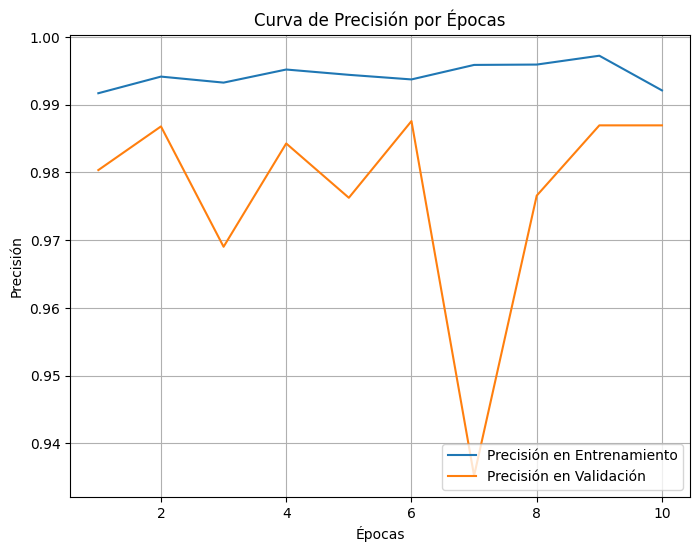

In [ ]:
#GRAFICA DE PRECISION CON 10 ETAPAS

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=validation_steps
)

!pip install matplotlib

import matplotlib.pyplot as plt

# Extraer las métricas de precisión del historial de entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Crear un gráfico con los valores de precisión por épocas
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Precisión en Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión en Validación')
plt.title('Curva de Precisión por Épocas')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
model.save('modelo_entrenado.keras')
from google.colab import files
files.download('modelo_entrenado.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>